### import package

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import shapiro
import os 

### Read Data

In [3]:
Input_Folder = os.path.abspath('../A:B Test/Data')
Data_Csv     = os.path.join(Input_Folder,'AB_Test_Results.csv')
df         = pd.read_csv(Data_Csv)

In [4]:
df

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
...,...,...,...
9995,1981,control,0.0
9996,502,variant,0.0
9997,9214,variant,0.0
9998,7741,control,0.0


### Data Describe

In [5]:
print(df.head())
print('-'*50)
print(df.nunique())
print('-'*50)
print(df.describe())

   USER_ID VARIANT_NAME  REVENUE
0      737      variant      0.0
1     2423      control      0.0
2     9411      control      0.0
3     7311      control      0.0
4     6174      variant      0.0
--------------------------------------------------
USER_ID         6324
VARIANT_NAME       2
REVENUE          101
dtype: int64
--------------------------------------------------
            USER_ID       REVENUE
count  10000.000000  10000.000000
mean    4981.080200      0.099447
std     2890.590115      2.318529
min        2.000000      0.000000
25%     2468.750000      0.000000
50%     4962.000000      0.000000
75%     7511.500000      0.000000
max    10000.000000    196.010000


In [6]:
double_variant_count = df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts()
print(double_variant_count / double_variant_count.sum())

1    0.756325
2    0.243675
Name: VARIANT_NAME, dtype: float64


In [7]:
# 將只在「對照組」or 「控制組」的名單users留下
single_variant_users = (df.groupby('USER_ID')['VARIANT_NAME'].nunique() == 1)
single_variant_users = single_variant_users[single_variant_users]

In [8]:
# 只保留single_variant_users的資料
df = df[df['USER_ID'].isin(single_variant_users.index)]
df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts().iloc[0] == double_variant_count.iloc[0]

True

<AxesSubplot:xlabel='VARIANT_NAME', ylabel='REVENUE'>

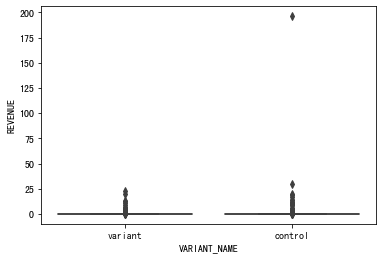

In [9]:
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=df)

In [10]:
df.sort_values(by='REVENUE', ascending=False).iloc[:10]

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01
8168,2166,control,29.32
2482,7356,variant,23.04
6412,1053,control,20.07
5217,3684,variant,19.47
5530,282,control,18.56
758,4445,control,17.05
4031,2059,control,14.24
9019,1973,control,14.07
4561,4966,variant,12.99


In [11]:
df = df[df['USER_ID'] != 3342]

([<matplotlib.axis.XTick at 0x7f9ea0324280>,
 [Text(0, 0, 'control'), Text(1, 0, 'variant')])

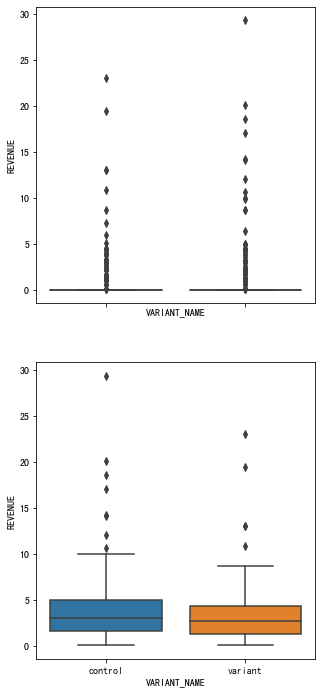

In [12]:
f, axes = plt.subplots(2, sharex=True, figsize=(5,12))
sns.boxplot(ax = axes[0], x = 'VARIANT_NAME', y = 'REVENUE', data = df)
sns.boxplot(ax = axes[1], x = 'VARIANT_NAME', y = 'REVENUE', data = df[df['REVENUE'] > 0])
plt.xticks(np.arange(2), ('control', 'variant'))

In [13]:
# 看看哪些users同時具有0 and positive revenue
(df.loc[
    (df['REVENUE'] == 0) & (df['USER_ID'].isin(df.loc[df['REVENUE'] > 0, 'USER_ID'].values)), 
    'USER_ID'
]).count()

52

In [14]:
df = df.groupby(by=['USER_ID', 'VARIANT_NAME']).sum().reset_index()

([<matplotlib.axis.XTick at 0x7f9ea0488e80>,
 [Text(0, 0, 'control'), Text(1, 0, 'variant')])

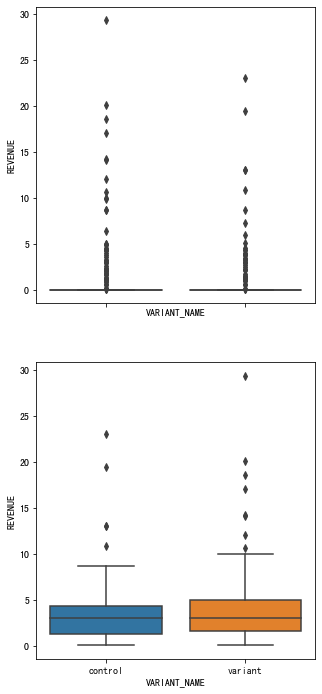

In [15]:
f, axes = plt.subplots(2, sharex=True, figsize=(5,12))
sns.boxplot(ax = axes[0], x = 'VARIANT_NAME', y = 'REVENUE', data = df)
sns.boxplot(ax = axes[1], x = 'VARIANT_NAME', y = 'REVENUE', data = df[df['REVENUE'] > 0])
plt.xticks(np.arange(2), ('control', 'variant'))

In [16]:
# 查看各組的指標
all_stat = df.groupby(by='VARIANT_NAME').agg({'USER_ID': 'nunique',
                                               'REVENUE': ['sum', 'mean', 'median', 'count']})

# 創造另外兩個指標
orders_per_user = all_stat.loc[:, ('REVENUE', 'count')] / all_stat.loc[:, ('USER_ID', 'nunique')]
revenue_per_user = all_stat.loc[:, ('REVENUE', 'sum')] / all_stat.loc[:, ('USER_ID', 'nunique')]

# 將其和原先指標做合併
all_stat.loc[:, ('per_user', 'orders')] = orders_per_user
all_stat.loc[:, ('per_user', 'revenue')] = revenue_per_user

all_stat

USER_ID REVENUE                        per_user          
             nunique     sum      mean median count   orders   revenue
VARIANT_NAME                                                          
control         2389  274.55  0.114923    0.0  2389      1.0  0.114923
variant         2393  179.32  0.074935    0.0  2393      1.0  0.074935

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

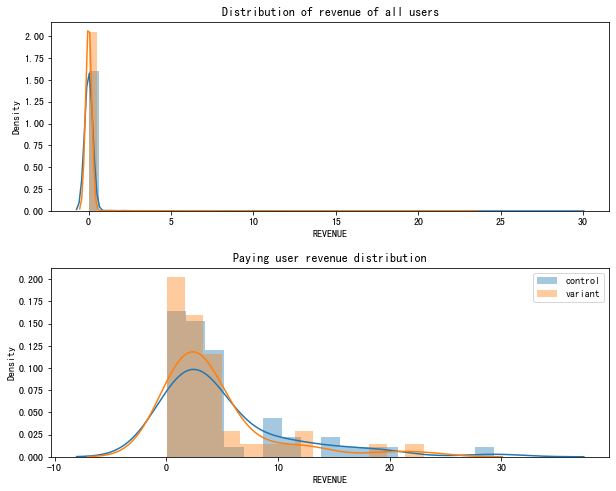

In [17]:
f, axes = plt.subplots(2, figsize=(10,8))
# 做一個for全部使用者的revenue分佈圖
sns.distplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
sns.distplot(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'], ax = axes[0], label='variant')
axes[0].set_title('Distribution of revenue of all users')

# 做一個for paying使用者的revenue分佈圖
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'control') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='control' )
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'variant') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='variant' )
axes[1].set_title('Paying user revenue distribution')
plt.legend()
plt.subplots_adjust(hspace = 0.3)

In [22]:
# 查看是否為normal distribution
T1 = shapiro(df.loc[df.VARIANT_NAME == 'variant', 'REVENUE'])
T2 = shapiro(df.loc[df.VARIANT_NAME == 'control', 'REVENUE'])
print('T1 P-values:',T1.pvalue)
print('T2 P-values:',T2.pvalue)
if T1.pvalue < 0.05:
    print('P-value is significant, so we can reject null hypothesis that T1 is Nomrally Distribution')
elif T1.pvalue > 0.05:
    print('T1 is Nomrally Distribution')
if T2.pvalue < 0.05:
    print('P-value is significant, so we can reject null hypothesis that T2 is Nomrally Distribution')
elif T2.pvalue > 0.05:
    print('T2 is Nomrally Distribution')

T1 P-values: 0.0
T2 P-values: 0.0
P-value is significant, so we can reject null hypothesis that T1 is Nomrally Distribution
P-value is significant, so we can reject null hypothesis that T2 is Nomrally Distribution


In [25]:
# 因為資料不服從Normally Distribution，我們改採用無母數統計中的mannwhitneyu檢定
# 此檢定可以判斷兩樣本的中位數是否相同
mannwhitneyu(df.loc[(df.VARIANT_NAME == 'variant') & (df.REVENUE > 0), 'REVENUE'], 
             df.loc[(df.VARIANT_NAME == 'control') & (df.REVENUE > 0), 'REVENUE'])

MannwhitneyuResult(statistic=1029.0, pvalue=0.2657096108542354)

In [30]:
def get_bootstrap_samples(data, n_samples=1000):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [31]:
control = get_bootstrap_samples(df.loc[df.VARIANT_NAME == 'control', 'REVENUE'].values, 10000)
variant = get_bootstrap_samples(df.loc[df.VARIANT_NAME == 'variant', 'REVENUE'].values, 10000)

In [33]:
control_paid = get_bootstrap_samples(df.loc[(df.VARIANT_NAME == 'control') & (df.REVENUE > 0), 'REVENUE'].values, 10000)
variant_paid = get_bootstrap_samples(df.loc[(df.VARIANT_NAME == 'variant') & (df.REVENUE > 0), 'REVENUE'].values, 10000)

Text(0.5, 1.0, 'Sample mean distribution for all users')

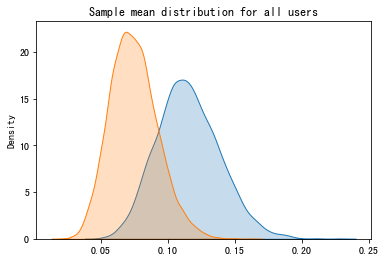

In [34]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(control, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for all users')

Text(0.5, 1.0, 'Sample mean distribution for paying users')

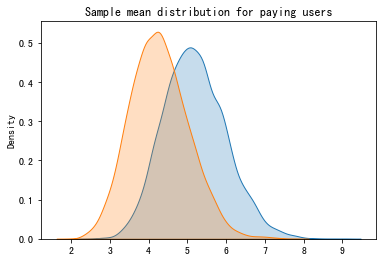

In [35]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(control_paid, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant_paid, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for paying users')

In [71]:
def plot_distribution_and_stat_intervals(variant, control, title, alpha=0.05):
    """ Plot the distribution of the mean difference and return the confidence intervals """
    f, ax = plt.subplots()
    # get data for coloring confidence intervals
    points = sns.kdeplot(variant - control, shade=False).lines[0].get_data()
    x = points[0]
    y = points[1]
    ymin, ymax = plt.ylim()
    # highlight the zero value and the bounds of the confidence interval
    plt.vlines(0, 0, ymax, label='0', color='gray')
    plt.vlines(stat_intervals(variant - control, alpha)[0], 0, ymax, linestyles="dashed")
    plt.vlines(stat_intervals(variant - control, alpha)[1], 0, ymax, linestyles="dashed")
    # color the confidence interval and zones outside it
    plt.fill_between(x,y,
                     where = (x >= stat_intervals(variant - control, alpha)[1]),
                     color='gainsboro')
    plt.fill_between(x,y,
                     where = (x <= stat_intervals(variant - control, alpha)[0]),
                     color='gainsboro')
    plt.fill_between(x,y,
                     where = ((x >= stat_intervals(variant - control, alpha)[0])
                              & (x <= stat_intervals(variant - control, alpha)[1])),
                     color='red',
                     label = '95% confidence interval')
    plt.title(f'Distribution of difference between means (variant - control) {title}; {100*(1-alpha)}% Confidence interval for difference of means: {stat_intervals(variant - control, alpha)}')
    plt.legend(prop={'size':13})
    # return confidence interval data
    return stat_intervals(variant - control)

array([-0.09910014,  0.01570045])

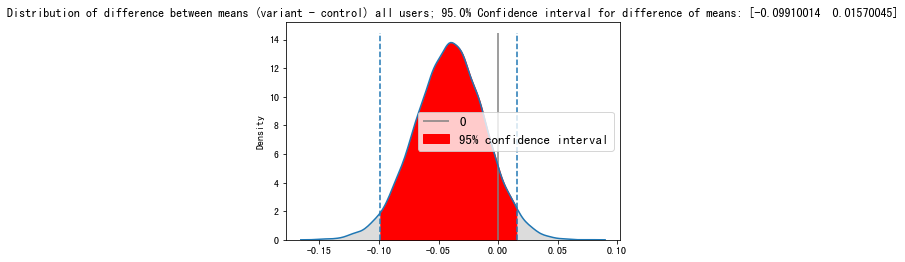

In [72]:
plot_distribution_and_stat_intervals(np.mean(variant, axis=1), 
                                     np.mean(control, axis=1),
                                     title='all users')